In [1]:
# General imports
import numpy as np
np.random.seed(42)
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import os
import yaml

from resum.multi_fidelity_gaussian_process import MultiFidelityVisualizer
from resum.multi_fidelity_gaussian_process import MFGPModel

In [2]:
path_to_settings = "../binary-black-hole"
with open(f"{path_to_settings}/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

version       = config_file["path_settings"]["version"]
path_out_cnp  = config_file["path_settings"]["path_out_cnp"]
path_out_mfgp = config_file["path_settings"]["path_out_mfgp"]
file_in=f'{path_out_cnp}/cnp_{version}_output.csv'


In [3]:

if not os.path.exists(path_out_mfgp):
   os.makedirs(path_out_mfgp)

# Set parameter name/x_labels -> needs to be consistent with data input file
x_labels        = config_file["simulation_settings"]["theta_headers"]
y_label_cnp     = 'y_cnp'
y_err_label_cnp = 'y_cnp_err'
y_label_sim     = 'y_raw'

# Set parameter boundaries
xmin = config_file["simulation_settings"]["theta_min"]
xmax = config_file["simulation_settings"]["theta_max"]
x_fixed = config_file["simulation_settings"]["theta_fixed"]
parameters={}
for i,x in enumerate(x_labels):
   parameters[x]=[xmin[i],xmax[i]]

# Assign costs
low_fidelity_cost = config_file["simulation_settings"]["lf_cost"]
high_fidelity_cost = config_file["simulation_settings"]["lf_cost"]

In [4]:
data=pd.read_csv(file_in)

In [5]:

LF_cnp_noise=np.mean(data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())
HF_cnp_noise=np.mean(data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())
LF_sim_noise=np.std(data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_label_sim].to_numpy())
HF_sim_noise=np.std(data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_sim].to_numpy())
print(HF_sim_noise)

x_train_l, x_train_h, y_train_l, y_train_h = ([],[],[],[])
row_h=data.index[data['fidelity'] == 1].tolist()
row_l=data.index[data['fidelity'] == 0].tolist()

x_train_hf_sim = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_hf_sim = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_sim].to_numpy().tolist()

x_train_hf_cnp = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_hf_cnp = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][ y_label_cnp].to_numpy().tolist()

x_train_lf_sim = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_lf_sim = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][ y_label_sim].to_numpy().tolist()

x_train_lf_cnp = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_lf_cnp = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][ y_label_cnp].to_numpy().tolist()


0.005938751458757041


In [6]:
#trainings_data = {"lf": [x_train_lf_cnp,y_train_lf_cnp], "mf": [x_train_hf_cnp,y_train_hf_cnp], "hf": [x_train_hf_sim,y_train_hf_sim]}
#noise = {"lf": LF_cnp_noise, "mf": HF_cnp_noise, "hf": 0.}

In [7]:
trainings_data = {"lf": [x_train_lf_cnp,y_train_lf_cnp], "hf": [x_train_hf_sim,y_train_hf_sim]}
noise = {"lf": LF_cnp_noise, "hf": 0.}

In [8]:
#trainings_data = {"lf": [x_train_lf_cnp,y_train_lf_cnp], "hf": [x_train_hf_sim,y_train_hf_sim]}
#noise = {"lf": LF_cnp_noise, "hf": 0.}

In [9]:
#trainings_data = {"lf": [x_train_lf_sim,y_train_lf_sim], "hf": [x_train_hf_sim,y_train_hf_sim]}
#noise = {"lf": LF_sim_noise, "hf": 0.}

In [10]:
import os
import importlib.util

# Path to the inequalities.py file
file_path = f"{path_to_settings}/inequalities.py"

if os.path.exists(file_path):
    spec = importlib.util.spec_from_file_location("inequalities", file_path)
    inequalities_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(inequalities_module)
    InequalityConstraints = inequalities_module.InequalityConstraints
    inequalities = InequalityConstraints()
    print("InequalityConstraints loaded successfully.")
else:
    inequalities = None

In [11]:
mf_model = MFGPModel(trainings_data,noise, inequality_constraints=inequalities)
mf_model.build_model(5)

 /Users/aschuetz/.local/modules/miniconda/miniconda3/envs/resum/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = -1070.2221684892138
Optimization restart 2/5, f = -1070.2224304242382
Optimization restart 3/5, f = -1070.2224305882119
Optimization restart 4/5, f = -1070.2224304734143
Optimization restart 5/5, f = -1071.5352641551979


In [12]:
mf_model.model.gpy_model

gp.,value,constraints,priors
multifidelity.sum.rbf.variance,1.323463578192259e-05,+ve,
multifidelity.sum.rbf.lengthscale,"(4,)",+ve,
multifidelity.sum.bias.variance,0.038226223166982196,+ve,
multifidelity.sum.Mat32.variance,9.621063552039253e-08,+ve,
multifidelity.sum.Mat32.lengthscale,"(4,)",+ve,
multifidelity.Mat32.variance,0.00018744851878202328,+ve,
multifidelity.Mat32.lengthscale,0.029705244731200422,+ve,
multifidelity.scale,0.08919326993859444,,
mixed_noise.Gaussian_noise.variance,0.02177173095944609,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,0.0,+ve fixed,


In [13]:
%%capture
leg_label = []
ncol=3
nrow=int(np.ceil(len(x_labels)/ncol))
fig2,_  = plt.subplots(nrow, ncol, figsize=(15, 5), constrained_layout=True)
fig4,_  = plt.subplots(int(np.ceil(len(x_labels)/1)), 1, figsize=(5, 12), constrained_layout=True)



In [14]:
mf_vis = MultiFidelityVisualizer(mf_model,parameters,x_fixed)

In [15]:

sample=0
add_new_sample=True
mf_model.set_traings_data(trainings_data)

while ( sample <= data['iteration'].max()):
    print('Sample #', sample)

    if sample > 0:    
         
        x_train_hf_sim = data[(data['fidelity']==1.) & (data['iteration']==sample)][x_labels].to_numpy().tolist()
        y_train_hf_sim = data[(data['fidelity']==1.) & (data['iteration']==sample)][y_label_sim].to_numpy().tolist()
        print(f"Adding {x_train_hf_sim}")   
        x_train_hf_cnp = data[(data['fidelity']==1.) & (data['iteration']==sample)][x_labels].to_numpy().tolist()
        y_train_hf_cnp = data[(data['fidelity']==1.) & (data['iteration']==sample)][y_label_cnp].to_numpy().tolist()

        x_train_lf_cnp = data[(data['fidelity']==0.) & (data['iteration']==sample)][x_labels].to_numpy().tolist()
        y_train_lf_cnp = data[(data['fidelity']==0.) & (data['iteration']==sample)][ y_label_cnp].to_numpy().tolist()
        trainings_data_new = {"lf": [x_train_lf_cnp,y_train_lf_cnp], "mf": [x_train_hf_cnp,y_train_hf_cnp], "hf": [x_train_hf_sim,y_train_hf_sim]}
        mf_model.set_data(trainings_data_new)


    # run the model drawing
    fig1, ax = plt.subplots(2, 3,figsize=(15, 5),constrained_layout=True)
    fig1 = mf_vis.draw_model_projections(fig1)
    fig2 = mf_vis.draw_model_projections(fig2)

    # find the next data point
    #x_next_sample, us_acquisition = mf_model.max_acquisition_integrated_variance_reduction(parameters)
    #print(f'next suggested point to simulated is at: {x_next_sample}')
    #fig4 = mf_vis.draw_acquisition_func(fig4, us_acquisition, np.array(x_next_sample))
    sample+=1




Sample # 0


<IPython.core.display.Javascript object>

In [16]:
fig1.savefig(f"{path_out_mfgp}/mfgp_{version}_model_proj.png")
fig2.savefig(f"{path_out_mfgp}/mfgp_{version}_model_proj_updated.png")

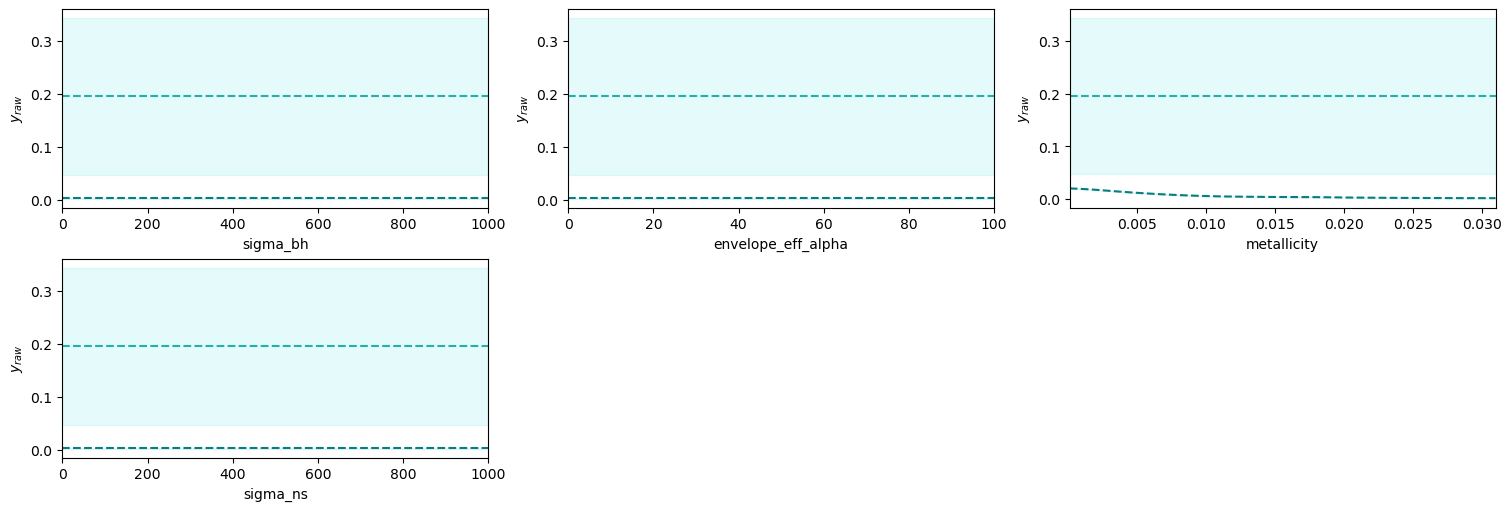

In [23]:
fig1

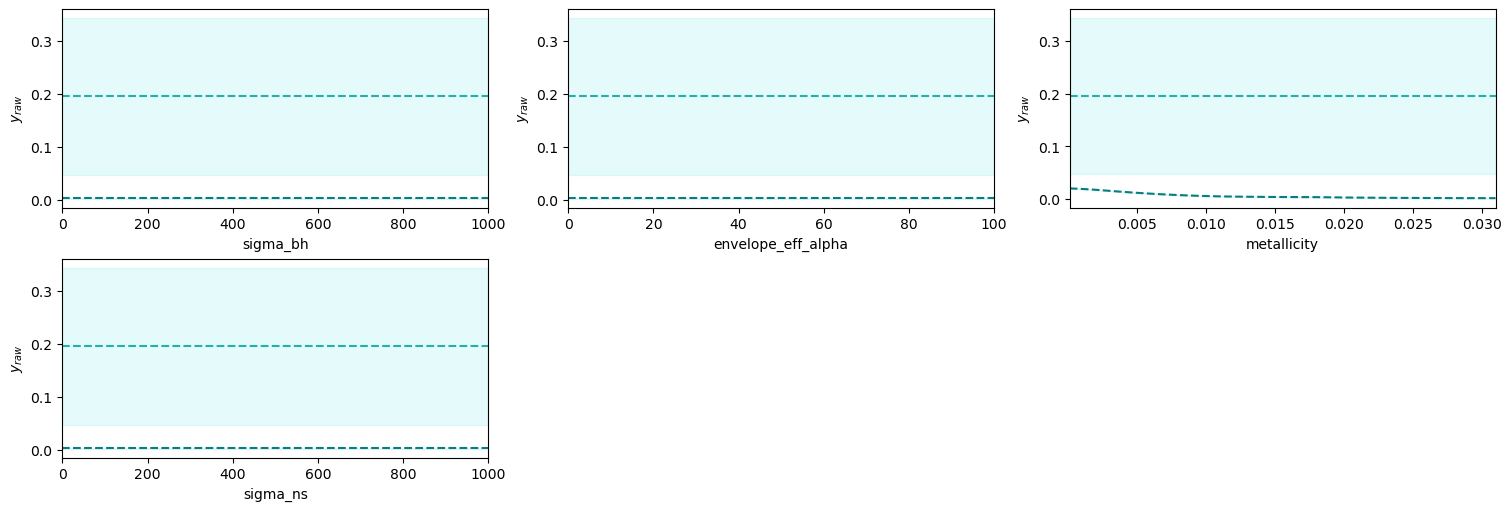

In [24]:
fig2

In [17]:
fig4.savefig(f"{path_out_mfgp}/mfgp_{version}_model_acq.png")

In [18]:
fig3 = mf_vis.draw_model()
fig3.savefig(f"{path_out_mfgp}/mfgp_{version}_model.png")

<IPython.core.display.Javascript object>

In [19]:
config_file["path_settings"]["path_to_files_validation"]

'../binary-black-hole/out/cnp/cnp_v1.1_output_validation.csv'

In [20]:
data_test=pd.read_csv(config_file["path_settings"]["path_to_files_validation"])
print(config_file["path_settings"]["path_to_files_validation"])
x_test=[]
y_test=[]
x_test.append(data_test.loc[data_test['fidelity']==0.][x_labels].to_numpy().tolist())
y_test.append(data_test.loc[data_test['fidelity']==0.][y_label_cnp].to_numpy().tolist())
#x_test.append(data_test.loc[data_test['fidelity']==1.][x_labels].to_numpy().tolist())
#y_test.append(data_test.loc[data_test['fidelity']==1.][y_label_cnp].to_numpy().tolist())
x_test.append(data_test.loc[data_test['fidelity']==1.][x_labels].to_numpy().tolist())
y_test.append(data_test.loc[data_test['fidelity']==1.][y_label_sim].to_numpy().tolist())
fig5, validation  = mf_vis.model_validation(x_test, y_test)
plt.show()

../binary-black-hole/out/cnp/cnp_v1.1_output_validation.csv


<IPython.core.display.Javascript object>

In [21]:
for x in range(len(x_labels)):
    fig5 = mf_vis.draw_model_marginalized(x,grid_steps=5)
    fig5.savefig(f"{path_out_mfgp}/mfgp_{version}_marg_{x}.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

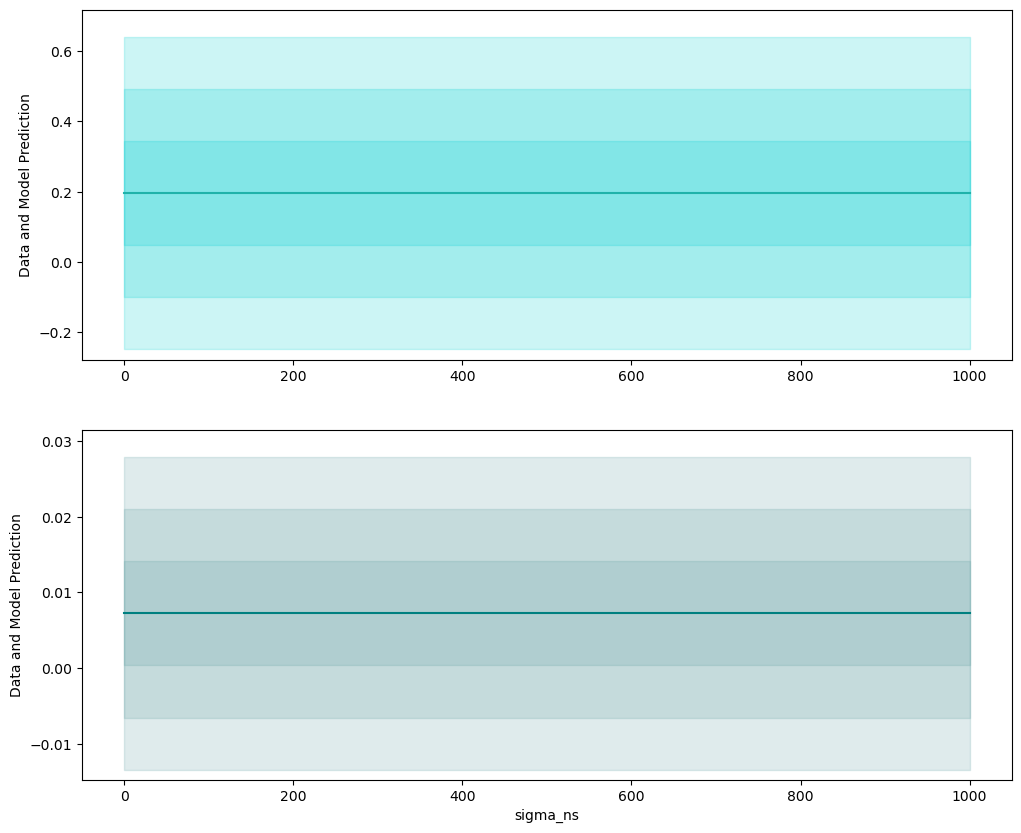

In [22]:
fig5